Autor: Adam Szczepaniak

Data: 2025-01-16

Treść zadania:
Stworzenie, wytrenowanie oraz ocena modelu rekurencyjnej sieci neuronowej, służącej do analizy szeregów czasowych, opisujących zanieczyszczenie powietrza w Pekinie (Chiny) w latach 2013–2017. Dostępnych jest kilka zbiorów danych, zebranych z różnych stacji meteorologicznych na terenie tego miasta – my skupimy się na punkcie pomiarowym, położonym w pobliżu Świątyni Wanshou (Wanshouxigong), w północno-zachodniej dzielnicy metropolii.

This project has been made during Polish-Japanese Academy of Information Technology postgraduate studies.

# Importy

In [1]:
#ignore warnings
import warnings
warnings.simplefilter ('ignore')

#trans libs
import pandas as pd
import numpy as np
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose

#visualisation libs
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#ML libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

#setup pandas
pd.set_option ('display.width',100)
pd.set_option ('display.max_rows',50)
pd.set_option ('display.max_columns',20)

#setup seaborn
sns.set_style ('whitegrid')
sns.set_context ('paper', font_scale = 1.1)

#setup matplotlib
mpl.rcParams['font.family'] ='serif'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'semibold'

# 1. Wczytanie zbioru danych

In [2]:
f_path = '/content/drive/MyDrive/Colab Notebooks/PRSA/PRSA_Data_Wanshouxigong_20130301-20170228.csv'
df = pd.read_csv(f_path, usecols = lambda cols: cols not in ['No', 'wd', 'station'])
df.head(3)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,2.0
1,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,4.4
2,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,4.7


## Utworzenie kolumny "Date" i zmiana indeksu

In [3]:
dfc = df.copy()
dfc['Date'] = pd.to_datetime(dfc[['year', 'month', 'day', 'hour']])

In [4]:
dfc.set_index('Date', inplace = True)
dfc.index.freq = 'h'

In [5]:
dfc.drop(columns = ['year', 'month', 'day', 'hour'], inplace = True)
dfc.head(3)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
Date,,,,,,,,,,,
2013-03-01 00:00:00,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,2.0
2013-03-01 01:00:00,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,4.4
2013-03-01 02:00:00,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,4.7


# 2. Rzut okiem na dane

## Struktura zbioru

In [6]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Freq: h
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   34368 non-null  float64
 1   PM10    34580 non-null  float64
 2   SO2     34395 non-null  float64
 3   NO2     34310 non-null  float64
 4   CO      33767 non-null  float64
 5   O3      33986 non-null  float64
 6   TEMP    35045 non-null  float64
 7   PRES    35045 non-null  float64
 8   DEWP    35045 non-null  float64
 9   RAIN    35045 non-null  float64
 10  WSPM    35051 non-null  float64
dtypes: float64(11)
memory usage: 3.2 MB


## Wartości puste i duplikaty

In [7]:
print(f"Suma wartości pustych w poszczególnych kolumnach:")
dfc.isnull().sum()

Suma wartości pustych w poszczególnych kolumnach:


,0
PM2.5,696
PM10,484
SO2,669
NO2,754
CO,1297
O3,1078
TEMP,19
PRES,19
DEWP,19
RAIN,19


In [8]:
f"Ilość duplikatów: {dfc.duplicated().sum()}"

'Ilość duplikatów: 0'

## Statystyki danych

In [9]:
dfc.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,34368.000000,34580.000000,34395.000000,34310.00000,33767.000000,33986.000000,35045.000000,35045.000000,35045.000000,35045.000000,35051.000000
mean,85.024136,112.223459,17.148603,55.52956,1370.395031,56.229904,13.784477,1011.511804,2.707442,0.064320,1.745314
std,85.975981,97.593210,23.940834,35.80805,1223.139114,57.082710,11.385156,10.570928,13.704139,0.796981,1.206355
min,3.000000,2.000000,0.285600,2.00000,100.000000,0.214200,-16.800000,985.100000,-35.300000,0.000000,0.000000
25%,23.000000,39.000000,3.000000,28.00000,600.000000,8.000000,3.400000,1002.800000,-8.500000,0.000000,0.900000
50%,60.000000,91.000000,8.000000,49.00000,1000.000000,42.000000,14.800000,1011.000000,3.300000,0.000000,1.400000
75%,116.000000,154.000000,21.000000,77.00000,1700.000000,82.000000,23.500000,1020.000000,15.200000,0.000000,2.300000
max,999.000000,961.000000,411.000000,251.00000,9800.000000,358.000000,40.600000,1042.000000,28.500000,46.400000,13.200000


## Opis danych

### Opis zbioru

Zbiór składa się z 11 kolumn i 35064 wierszy. Wszystkie kolumny zawierają wartości rzeczywiste (float 64). We wszystkich kolumnach znajdują się wartości puste, które należy poddać dalszej analizie. Wiersze zbioru nie są zduplikowane.

### Interpretacja wartości poszczególnych kolumn

**PM2.5**: Stężenie pyłów w powietrzu- cząsteczki o średnicy ≤ 2.5 µm. Najbardziej szkodliwe zanieczyszczenie. Jego wysokie stężenie może powodować poważne problemy zdrowotne, zwłaszcza dla układu oddechowego i sercowo- naczyniowego. Wartości najczęściej podaje się w µg/m³. W datasecie wartości oscylują  między 3.0 i 999.0. W kolumnie brakuje danych dla 696 wierszy. Wiersze te zostaną usunięte. **Zmienna celu**.

**PM10**: Stężenie pyłów w powietrzu- cząsteczki o średnicy ≤ 10 µm. To zanieczyszczenie jet również szkodliwe, zawiera rakotwórcze metale ciężkie, m.in. benzopireny, furany, dioksyny. Wartości najczęściej podaje się w µg/m³. W datasecie znajdują się wartości między 2.0 i 961.0. W kolumnie brakuje danych dla 484 wierszy. Wiersze te zostaną uzupełnione.

**SO2**: Stężenie gazów w powietrzu- dwutlenek siarki, związany głównie ze spalaniem paliw kopalnych i emisjami przemysłowymi. Wartości najczęściej podaje się w µg/m³ lub ppb. W kolumnie znajdują się wartości między 0.28 i 411.0. Brakuje danych dla 669 wierszy. Dane te zostaną uzupełnione.

**NO2**: Stężenie gazów w powietrzu- dwutlenek azotu, produkt emisji pojazdów i procesów przemysłowych. Wartości najczęściej podaje się w µg/m³ lub ppb. W kolumnie znajdują się wartości między 2.0 i 251.0. Brakuje danych dla 754 wierszy. Dane te zostaną uzupełnione.

**CO**: Stężenie gazów w powietrzu- tlenek węgla, wynik spalania niepełnego paliw. Wartości najczęściej podaje się w mg/m³ lub ppm. W kolumnie znajdują się wartości między 100.0 i 9800.0. Brakuje danych dla 1297 wierszy. Dane te zostaną uzupełnione.

**O3**: Stężenie gazów w powietrzu- ozon, składnik smogu fotochemicznego. Wartości najczęściej podaje się w µg/m³ lub ppb. W kolumnie znajdują się wartości między 0.21 i 358.0. Brakuje danych dla 1078 wierszy. Dane te zostaną uzupełnione.

**TEMP**- Temperatura powietrza, podawana zazwyczaj w °C. W kolumnie znajdują się wartości między -16.80 i 40.60. Brakuje danych dla 19 wierszy. Dane te zostaną uzupełnione.

**PRES**: Ciśnienie atmosferyczne, podawane zazwyczaj w hPa. W kolumnie znajdują się wartości między 985.10 i 1042.00. Brakuje danych dla 19 wierszy. Dane te zostaną uzupełnione.

**DEWP**: Punkt rosy, oznaczający temperaturę, w której powierze staje się nasycone. Podawane zazwyczaj w °C. W kolumnie znajdują się wartości między -35.30 i 28.50. Brakuje danych dla 19 wierszy. Dane te zostaną uzupełnione.

**RAIN**: Opady atmosferyczne, podawane zazwyczaj w mm. W kolumnie znajdują się wartości między 0.0 (brak opadów) i 46.40. Brakuje danych dla 19 wierszy. Dane te zostaną uzupełnione.

**WSPM**: Prędkość wiatru, podawane zazwyczaj w m/s. W kolumnie znajdują się wartości między 0.0 (brak wiatru) i 13.20. Brakuje danych dla 19 wierszy. Dane te zostaną uzupełnione.

# Obsługa wartości pustych w kolumnach

## Usunięcie wierszy pustych z kolumny 'PM2.5'

In [10]:
dfc.dropna(subset = 'PM2.5', inplace = True)
dfc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34368 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   34368 non-null  float64
 1   PM10    34351 non-null  float64
 2   SO2     34126 non-null  float64
 3   NO2     34037 non-null  float64
 4   CO      33496 non-null  float64
 5   O3      33682 non-null  float64
 6   TEMP    34349 non-null  float64
 7   PRES    34349 non-null  float64
 8   DEWP    34349 non-null  float64
 9   RAIN    34349 non-null  float64
 10  WSPM    34355 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


## Uzupełnienie wartości pustych w pozostałych kolumnach

In [11]:
for column in dfc.columns[1:]:
  dfc[column].interpolate(method = 'linear', inplace = True)

dfc.isnull().any()

,0
PM2.5,False
PM10,False
SO2,False
NO2,False
CO,False
O3,False
TEMP,False
PRES,False
DEWP,False
RAIN,False


# Eksploracyjna analiza danych (EDA)

## Ustawienie palety kolorów

In [12]:
#zastosowanie palety kolorów 'Paired'
cols = dfc.columns.to_list()
palette = sns.color_palette("Paired").as_hex()
del palette[10]

#słownik kolumn oraz przyporządkowanych do nich kolorów
colors = dict(zip (cols, palette))

## Funkcje- wykresy

In [13]:
#funcja tworząca histogram i boxplot dla pojedyńczej kolumny
def hist_box(x):

    cols = 2
    rows = 1

    #wyliczenie skośności i kurtozy dla analizowanej kolumny
    skew = round (x.skew(), 4)
    kurtosis = round (x.kurtosis(), 4)

    fig, axes = plt.subplots (nrows = rows, ncols = cols, figsize = (15, 5))
    axes = axes.flatten()

    sns.histplot(x,
                ax = axes[0],
                bins = 60,
                stat = 'count',
                kde = True,
                color = colors.get(x.name),
                linewidth = 1,
                edgecolor = 'black',
                line_kws = {'linestyle':'dashed', 'linewidth':2, 'alpha':0.2})

    sns.boxplot(x, ax = axes[1], orient = 'h', color = colors.get(x.name),
                boxprops ={'edgecolor': "black", 'linewidth': 1.5},
                medianprops = {'color': 'lightgreen','linewidth' : 2},
                flierprops = {'markerfacecolor': 'red', 'marker': 'o', 'markersize': 4, 'markeredgecolor' : 'red'})

    plt.suptitle(f"Histogram and Boxplot dla kolumny {x.name}")
    axes[0].set_xlabel('')

    #okienko z wyliczeniem skośności i kurtozy:
    plt.text(0.39, 0.8, f'Skew:     {skew}\nKurtosis: {kurtosis}',
             bbox = dict(facecolor = f'{colors.get(x.name)}',
                         edgecolor = 'black',alpha = 0.5),transform = plt.gcf().transFigure)
    plt.show()

    x_desc = x.describe().to_frame().transpose()
    x_desc['RSD'] = np.round ((x.std() / x.mean()) * 100.0, 2)
    return x_desc

In [14]:
#funkcja dekompozycji szeregów czasowych
def decomp (x, period):
    decomposition = seasonal_decompose(x, model='addative', period = period)
    color = colors.get(x.name)
    fig = decomposition.plot()
    fig.set_figwidth(12)
    fig.set_figheight(8)

    for ax, label in zip(fig.axes, ['Observed', 'Trend', 'Seasonal', 'Residual']):
        for line in ax.get_lines():
            line.set_color(color)
            line.set(linewidth = 1)
        if label == 'Residual':  #wykres reszt
            for line in ax.get_lines():
                line.set_marker('o')  #ustawienie kropki jako markera
                line.set_markersize(1.5)  #ustawienie rozmiaru markera

    plt.title(f'Wykres sezonowości i trendu dla kolumny {x.name}', loc = 'center', fontdict = {'fontsize': 15, 'fontweight': 'semibold'}, y = 0.96,
             bbox = dict(facecolor = 'white', edgecolor = 'white'),transform = plt.gcf().transFigure)

    plt.show()

## Analiza rozkładu zmiennych

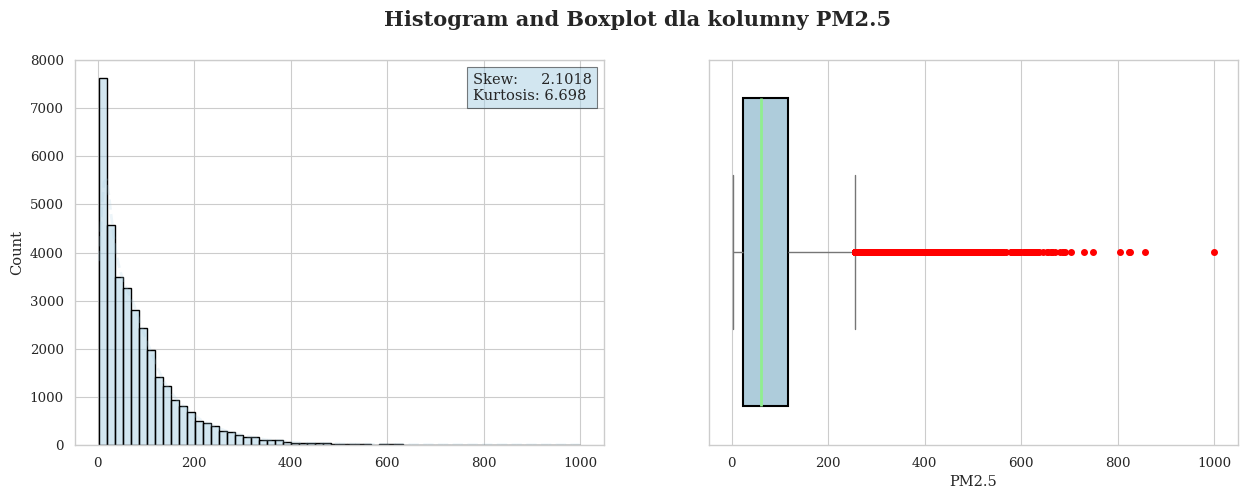

,count,mean,std,min,25%,50%,75%,max,RSD
PM2.5,34368.0,85.024136,85.975981,3.0,23.0,60.0,116.0,999.0,101.12


In [15]:
hist_box(dfc['PM2.5'])

**PM2.5**- Rozkład zmiennej jest prawoskośny (skew = 2.1018) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w niskich przedziałach. Rozkład przybiera wyższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = 6.698). Odchylenie standardowe (std = 85.976) i RSD = 101.12 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

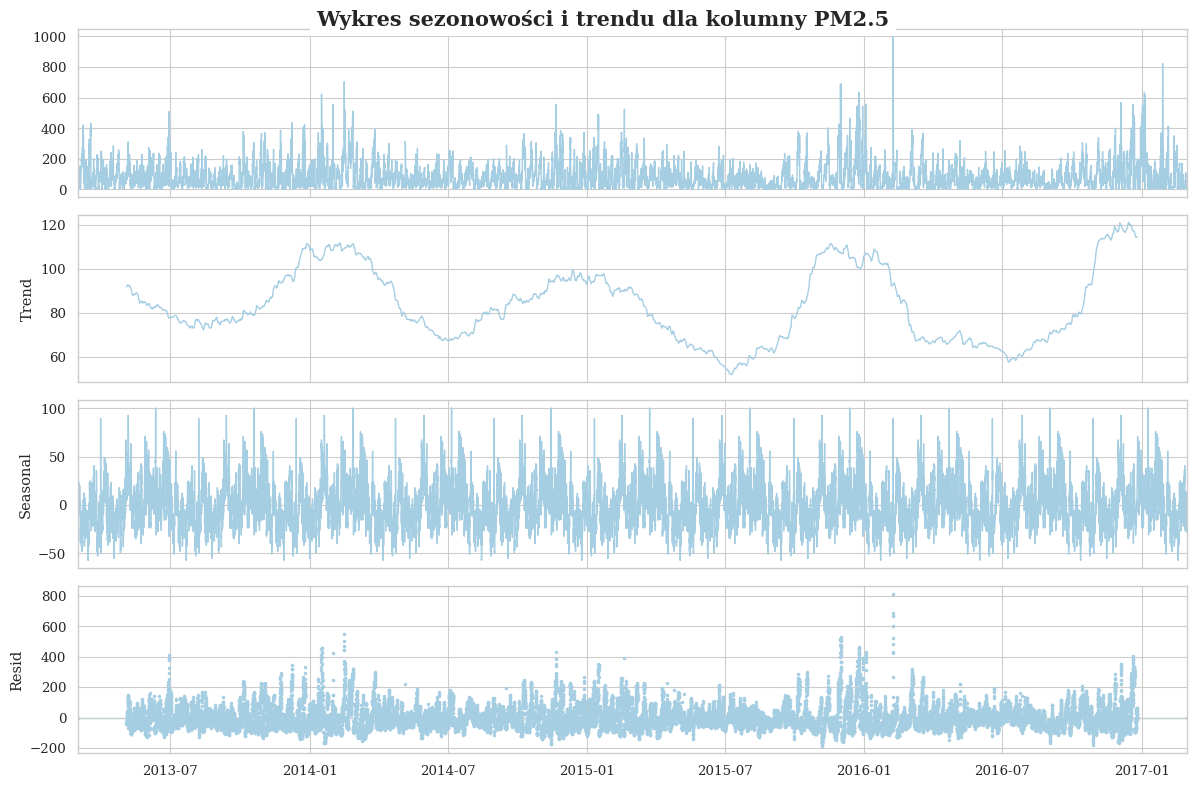

In [16]:
decomp (dfc['PM2.5'], 3072)

Wykres sezonowości i trendu ukazuje sezonowość roczną. Minima zanieczyszczeń **PM2.5** znajdują się w okolicach lipca- sierpnia każdego roku (okres letni), a maksima w okolicach grudnia- lutego (okres zimowy). Trend poziomu zanieczyszczeń jest malejący do lipca 2015, a następnie rośnie.

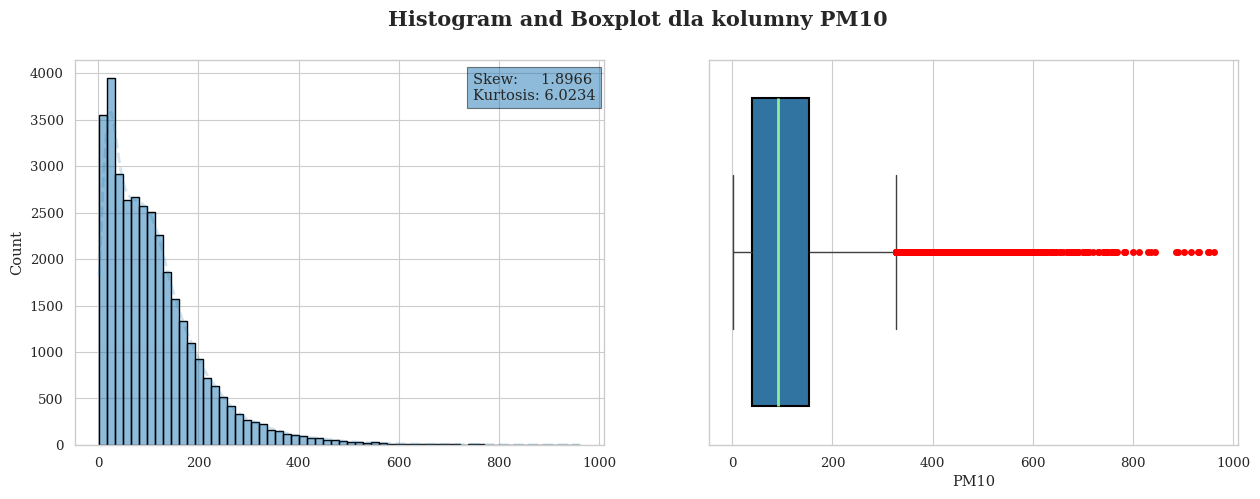

,count,mean,std,min,25%,50%,75%,max,RSD
PM10,34368.0,112.439121,98.050989,2.0,39.0,91.0,154.0,961.0,87.2


In [17]:
hist_box(dfc['PM10'])

**PM10**- Rozkład zmiennej jest prawoskośny (skew = 1.8966) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w niskich przedziałach. Rozkład przybiera wyższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = 6.0234). Odchylenie standardowe (std = 98.05) i RSD = 87.2 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

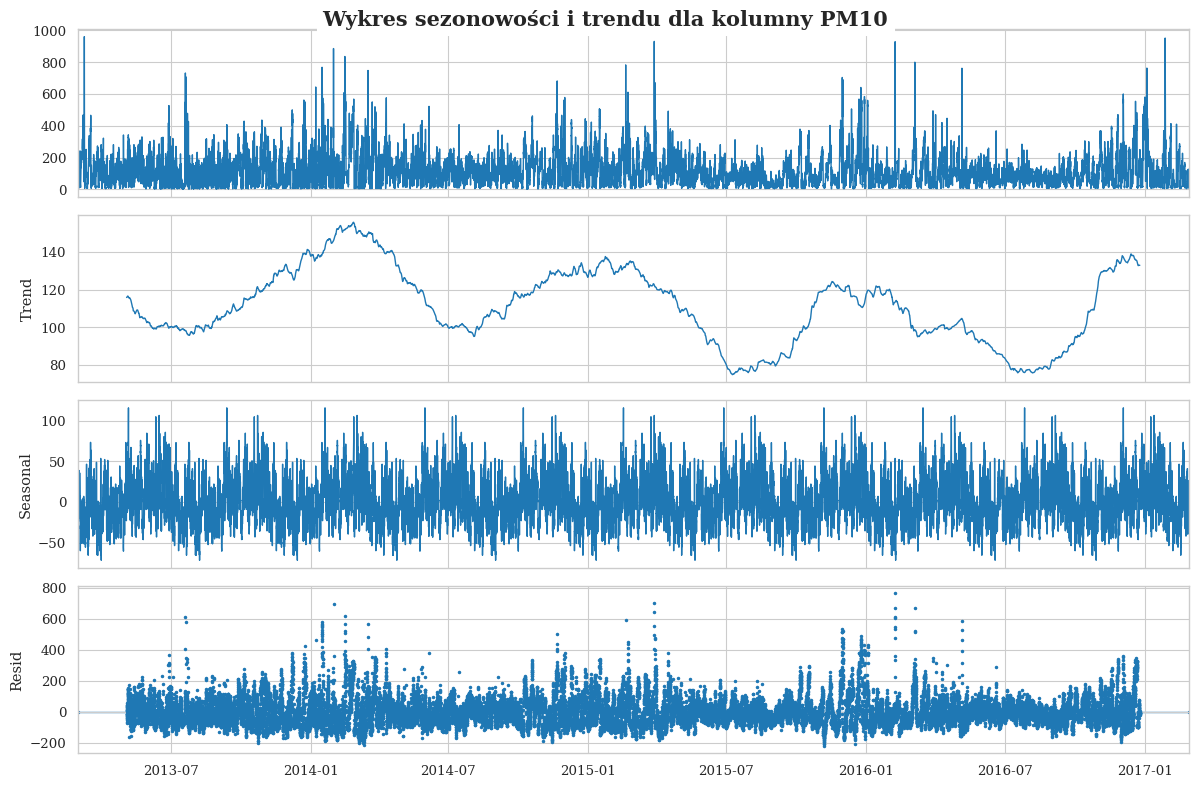

In [18]:
decomp (dfc['PM10'], 3072)

Podobnie jak dla PM2.5, wykres sezonowości i trendu kolumny **PM10** ukazuje minima zanieczyszczeń w okolicach lipca- sierpnia każdego roku (okres letni) i maksima w okolicach grudnia- lutego (okres zimowy)- sezonowość roczna. Trend poziomu zanieczyszczeń jest malejący do lipca 2015, a następnie rośnie.

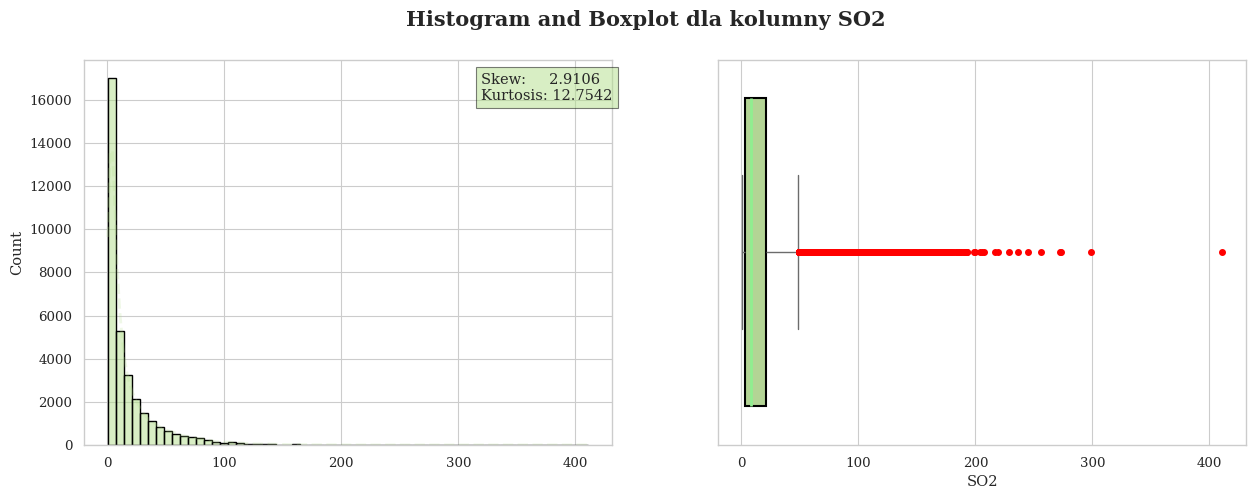

,count,mean,std,min,25%,50%,75%,max,RSD
SO2,34368.0,17.333003,24.133211,0.2856,3.0,8.0,21.0,411.0,139.23


In [19]:
hist_box(dfc['SO2'])

**SO2**- Rozkład zmiennej jest prawoskośny (skew = 2.9106) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w niskich przedziałach. Rozkład przybiera wyższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = 12.7542). Odchylenie standardowe (std = 24.133) i RSD = 139.23 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

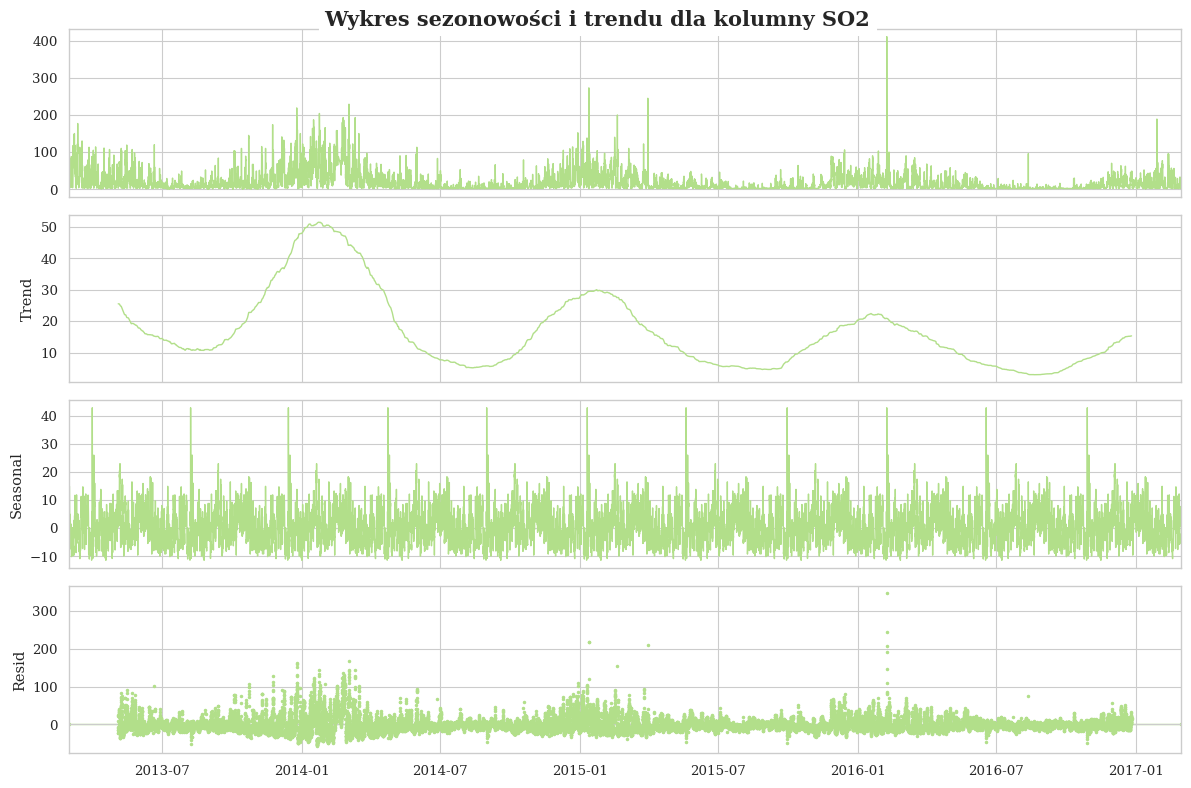

In [20]:
decomp (dfc['SO2'], 3072)

Wykres sezonowości i trendu kolumny **SO2** ukazuje minima zanieczyszczeń w okolicach września-października każdego roku (okres jesienny) i maksima w okolicach stycznia-marca (okres zimowy). Sezonowośc jest powtarzalna w cyklu rocznym. Trend poziomu zanieczyszczeń jest malejący.

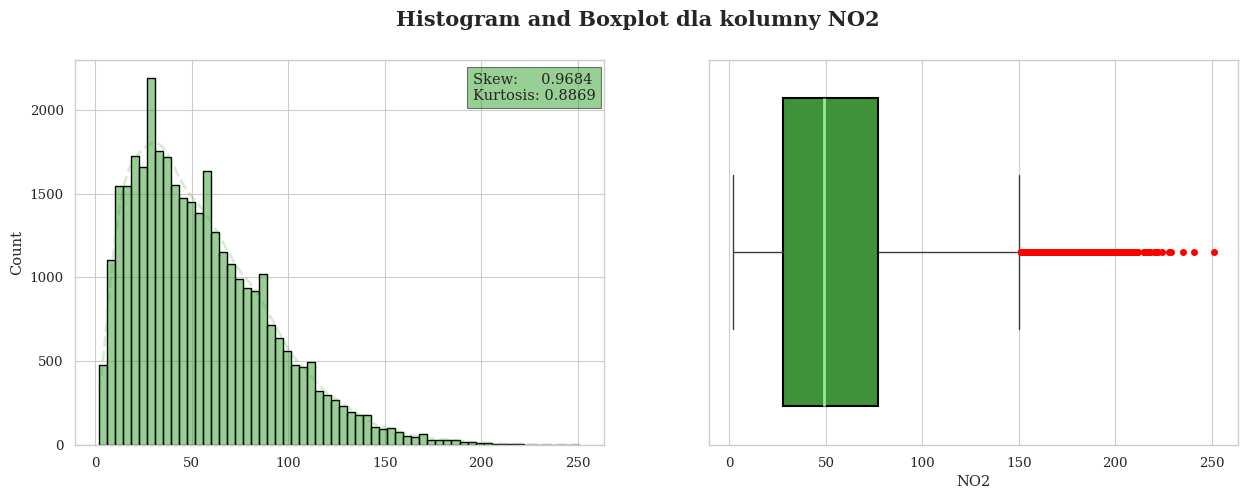

,count,mean,std,min,25%,50%,75%,max,RSD
NO2,34368.0,55.565462,35.771892,2.0,28.0,49.0,77.0,251.0,64.38


In [21]:
hist_box(dfc['NO2'])

**NO2**- Rozkład zmiennej jest umiarkowanie prawoskośny (skew = 0.9684) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w niskich przedziałach. Rozkład jest zbliżony do normalnego pod względem kształtów ogonów(kurtosis = 0.8869). Odchylenie standardowe (std = 35.77) i RSD = 64.38 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

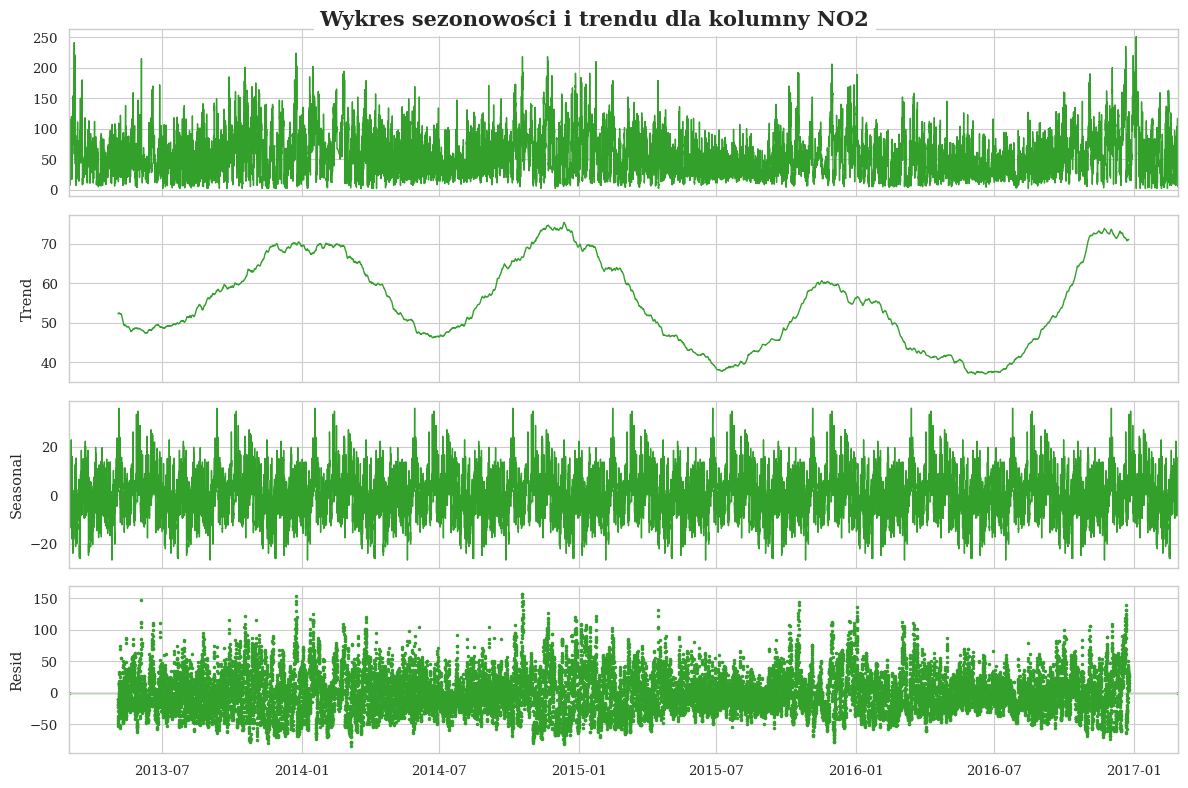

In [22]:
decomp (dfc['NO2'], 3072)

Wykres sezonowości i trendu kolumny **NO2** ukazuje minima zanieczyszczeń w okolicach czerwca- sierpnia każdego roku (okres letni) i maksima w okolicach grudnia- lutego (okres zimowy). Sezonowośc jest powtarzalna w cyklu rocznym. Trend poziomu zanieczyszczeń jest malejący.

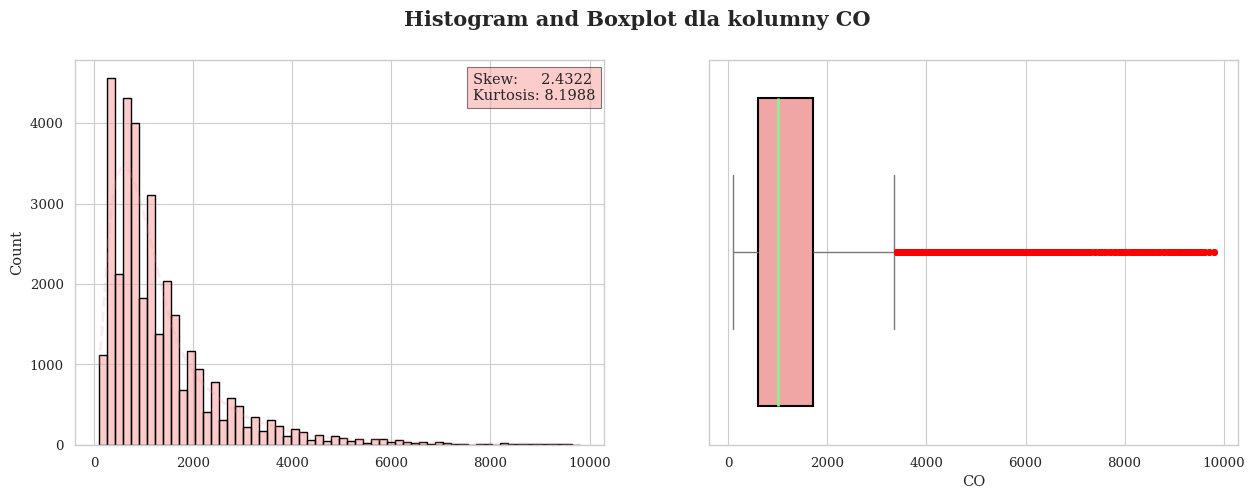

,count,mean,std,min,25%,50%,75%,max,RSD
CO,34368.0,1375.00515,1228.552034,100.0,600.0,1000.0,1700.0,9800.0,89.35


In [23]:
hist_box(dfc['CO'])

**CO**- Rozkład zmiennej jest prawoskośny (skew = 2.4322) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w niskich przedziałach. Rozkład przybiera wyższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = 8.1988). Odchylenie standardowe (std = 1228.55) i RSD = 89.35 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

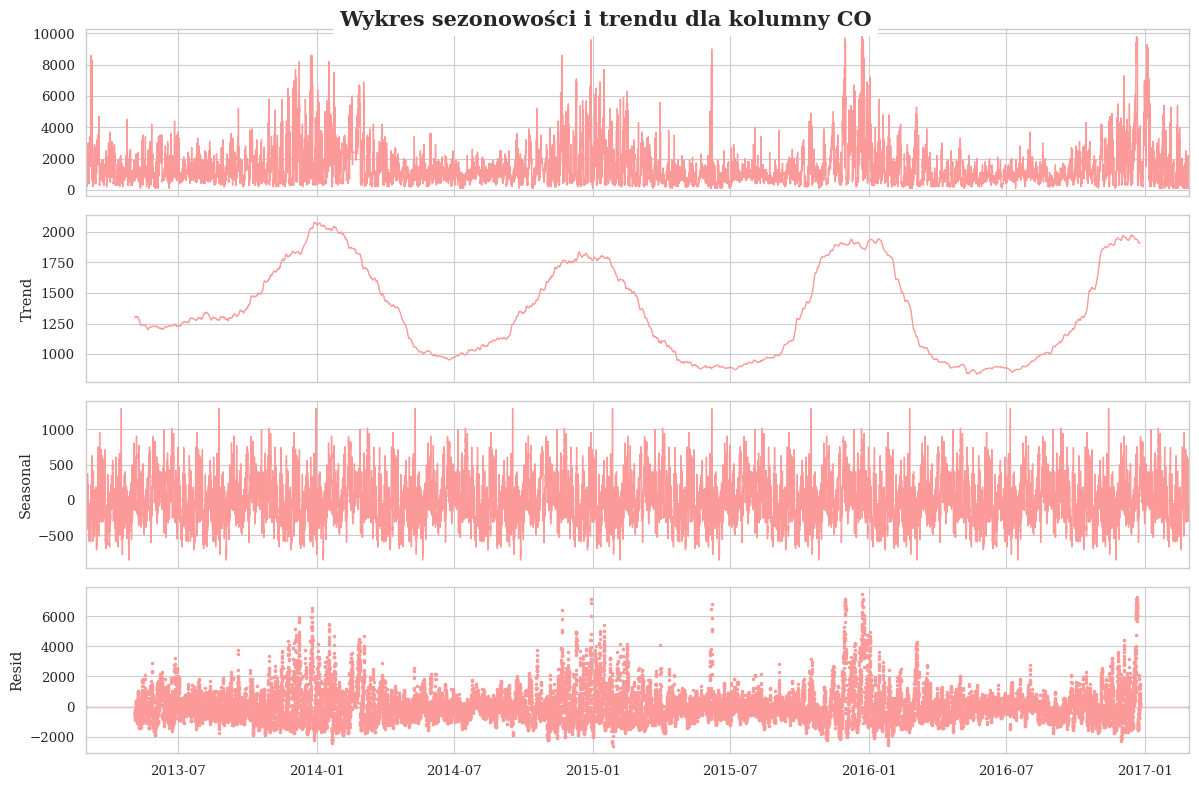

In [24]:
decomp (dfc['CO'], 3072)

Wykres sezonowości i trendu kolumny **CO** ukazuje minima zanieczyszczeń w okolicach czerwca- sierpnia każdego roku (okres letni) i maksima w okolicach grudnia- lutego (okres zimowy). Sezonowośc jest powtarzalna w cyklu rocznym. Trend poziomu zanieczyszczeń jest malejący.

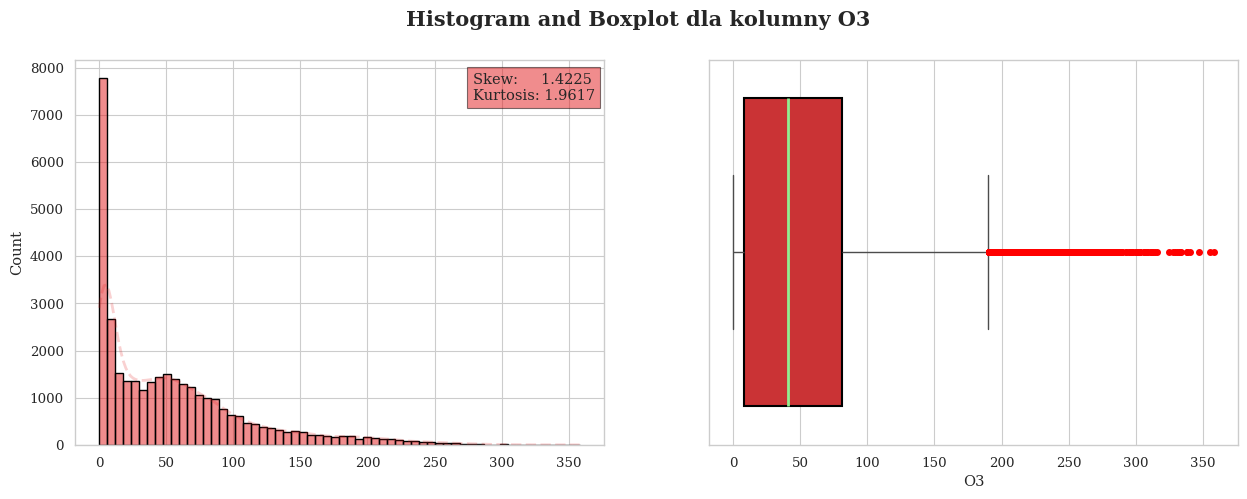

,count,mean,std,min,25%,50%,75%,max,RSD
O3,34368.0,55.447471,56.857033,0.2142,8.0,41.0,81.0,358.0,102.54


In [25]:
hist_box(dfc['O3'])

**O3**- Rozkład zmiennej jest prawoskośny (skew = 1.4225) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w niskich przedziałach. Rozkład jest zbliżony do normalnego pod względem kształtów ogonów(kurtosis = 1.9617). Odchylenie standardowe (std = 56.86) i RSD = 102.54 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

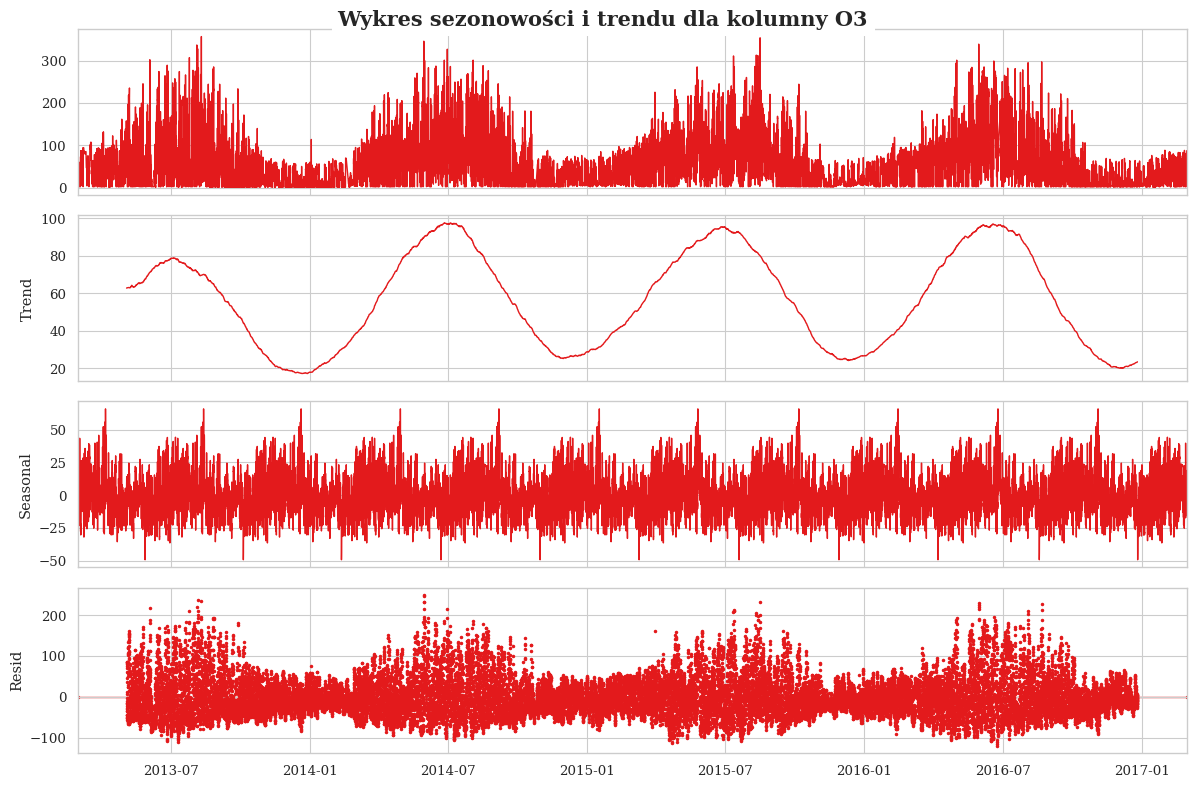

In [26]:
decomp (dfc['O3'], 3072)

Wykres sezonowości i trendu kolumny **O3** ukazuje minima w okolicach grudnia- lutego każdego roku (okres zimowy) i maksima w okolicach czerwca- sierpnia (okres letni). Sezonowośc jest powtarzalna w cyklu rocznym. Poziom trendu jest mniej więcej stały.

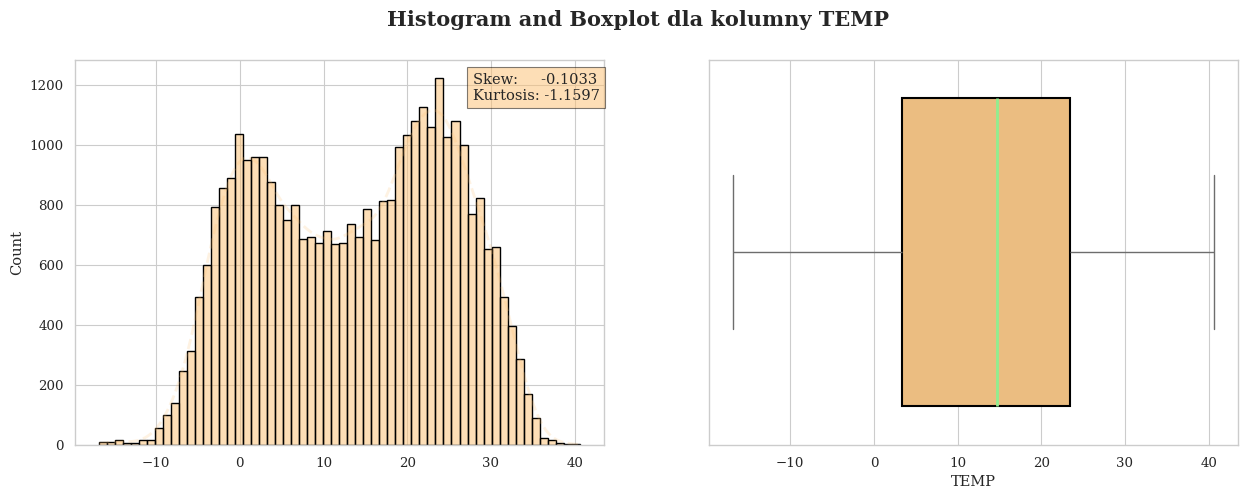

,count,mean,std,min,25%,50%,75%,max,RSD
TEMP,34368.0,13.730478,11.376962,-16.8,3.4,14.7,23.4,40.6,82.86


In [27]:
hist_box(dfc['TEMP'])

**TEMP**- Rozkład zmiennej jest dośc symetryczny (skew = -0.1033). Rozkład przybiera niższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = -1.1597). Odchylenie standardowe (std = 11.377) i RSD = 82.86 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie nie ma wartości odstających, znajdujących się poza zakresem 1.5 IQR.

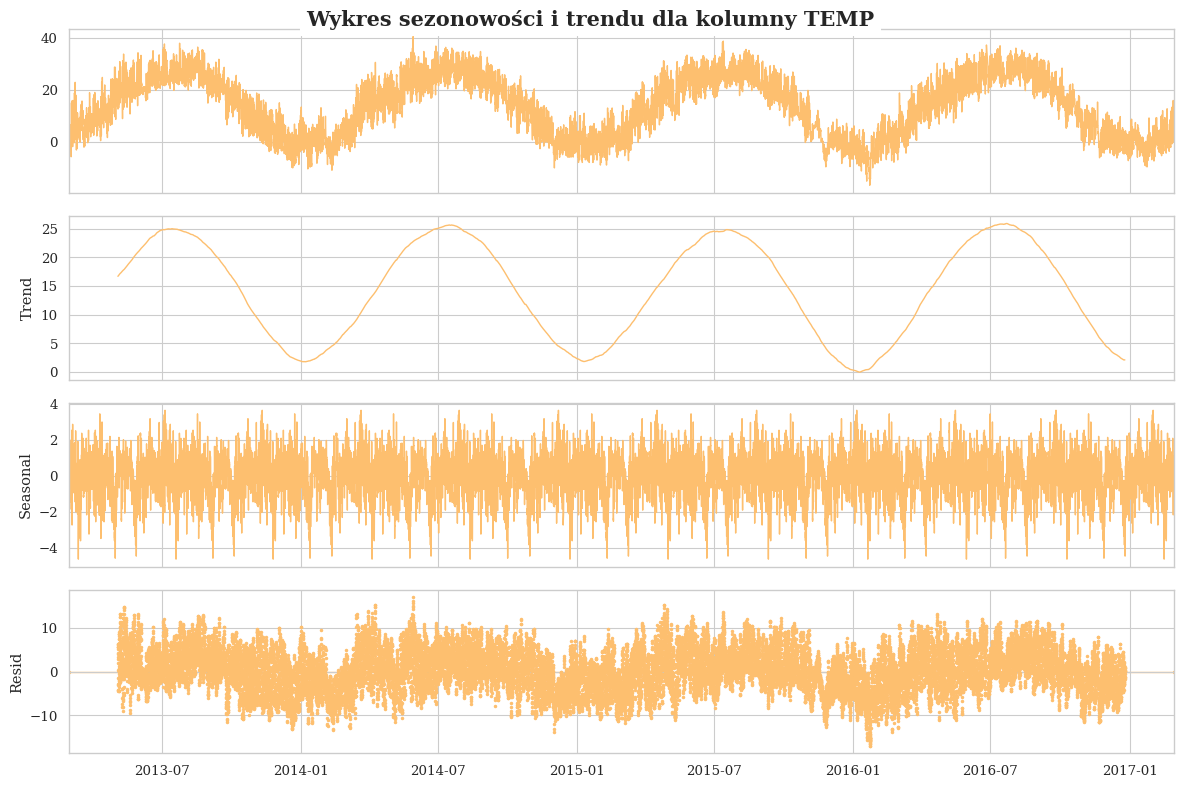

In [28]:
decomp (dfc['TEMP'], 3072)

Wykres sezonowości i trendu kolumny **TEMP** ukazuje minima w okolicach grudnia- lutego każdego roku (okres zimowy) i maksima w okolicach czerwca- sierpnia (okres letni). Sezonowośc jest powtarzalna w cyklu rocznym. Poziom trendu jest mniej więcej stały.

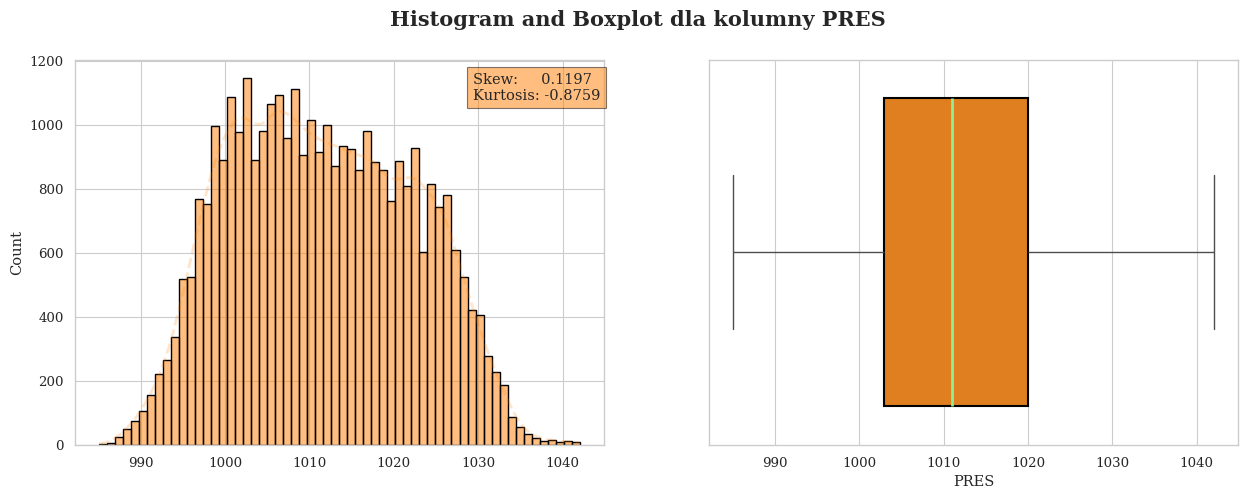

,count,mean,std,min,25%,50%,75%,max,RSD
PRES,34368.0,1011.53813,10.569808,985.1,1002.9,1011.0,1020.0,1042.0,1.04


In [29]:
hist_box(dfc['PRES'])

**PRES**- Rozkład zmiennej jest zbliżony do normalnego (skew = 0.1197). Rozkład przybiera niższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = -0.8759). Odchylenie standardowe (std = 10.569) i RSD = 1.04 oznacza, że wartości są w bardzo małym stopniu rozrzucone wokół średniej. W kolumnie nie ma wartości odstających, znajdujących się poza zakresem 1.5 IQR.

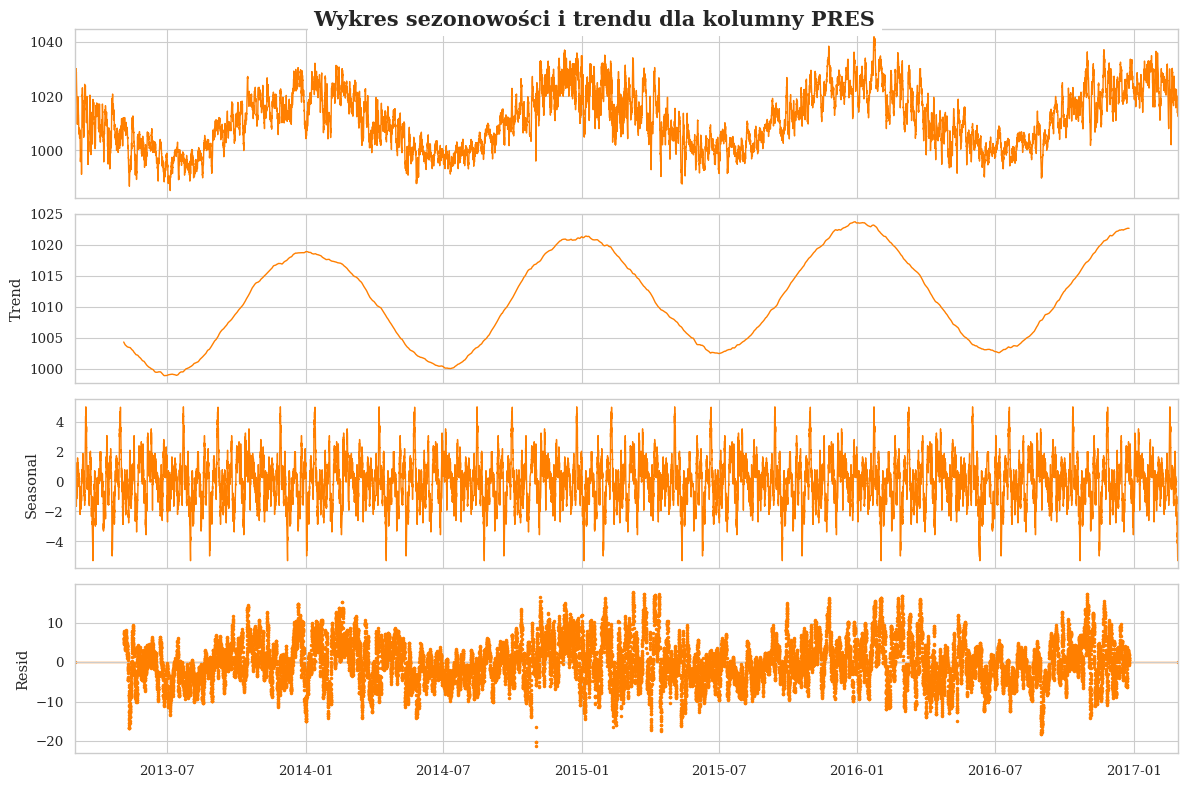

In [30]:
decomp (dfc['PRES'], 3072)

Wykres sezonowości i trendu kolumny **PRES** ukazuje maksima w okolicach grudnia- lutego każdego roku (okres zimowy) i minima w okolicach czerwca- sierpnia (okres letni). Sezonowośc jest powtarzalna w cyklu rocznym. Poziom trendu jest lekko rosnący.

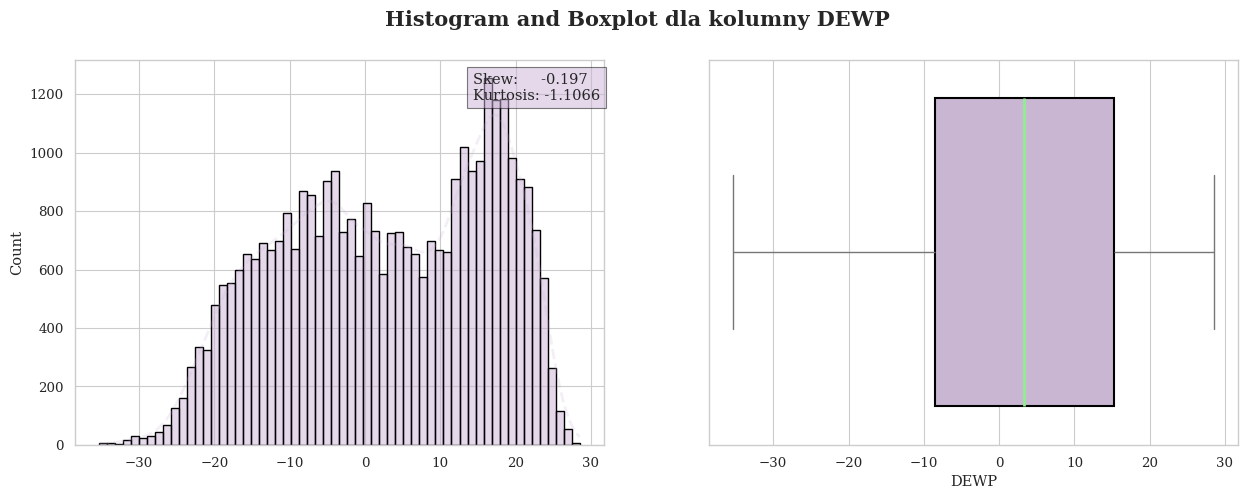

,count,mean,std,min,25%,50%,75%,max,RSD
DEWP,34368.0,2.677686,13.729979,-35.3,-8.5,3.3,15.3,28.5,512.76


In [31]:
hist_box(dfc['DEWP'])

**DEWP**- Rozkład zmiennej jest zbliżony do normalnego (skew = -0.197). Rozkład przybiera niższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = -1.1066). Odchylenie standardowe (std = 13.730) i RSD = 512.76 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie nie ma wartości odstających, znajdujących się poza zakresem 1.5 IQR.

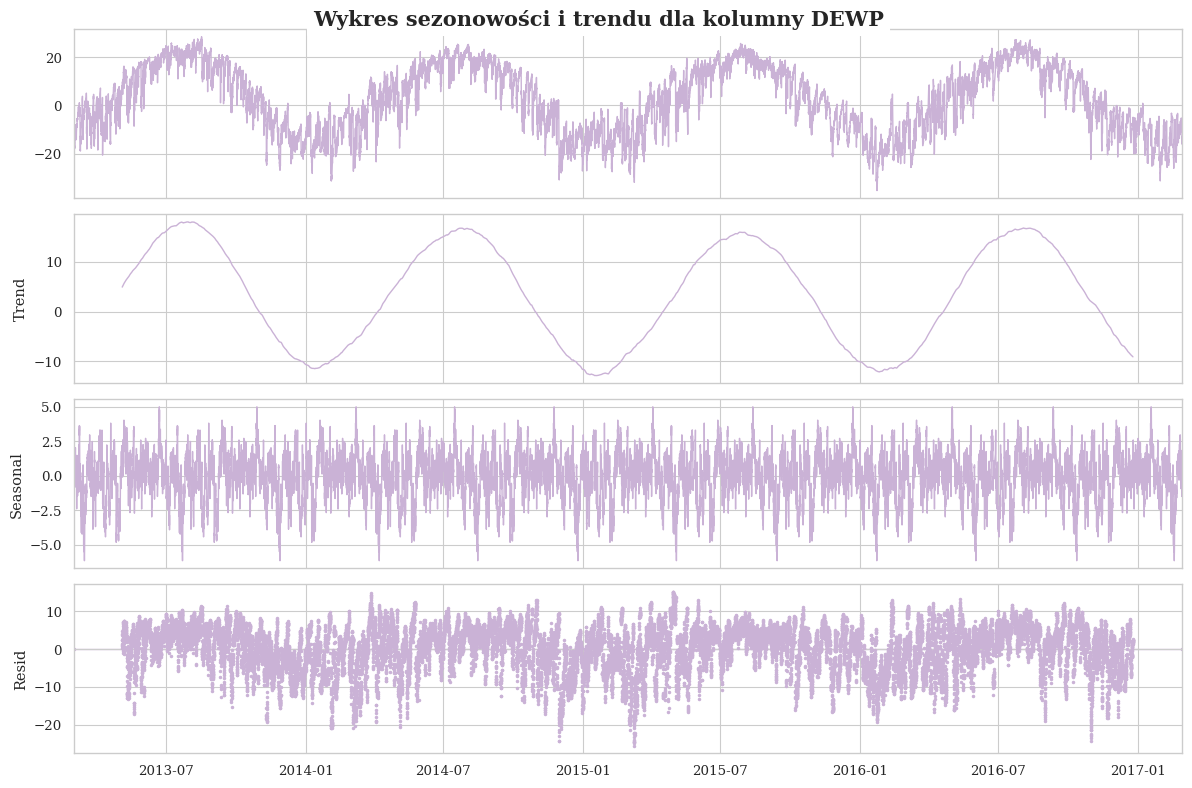

In [32]:
decomp (dfc['DEWP'], 3072)

Wykres sezonowości i trendu kolumny **DEWP** ukazuje minima w okolicach grudnia- lutego każdego roku (okres zimowy) i maksima w okolicach czerwca- sierpnia (okres letni). Sezonowośc jest powtarzalna w cyklu rocznym. Poziom trendu jest stały.

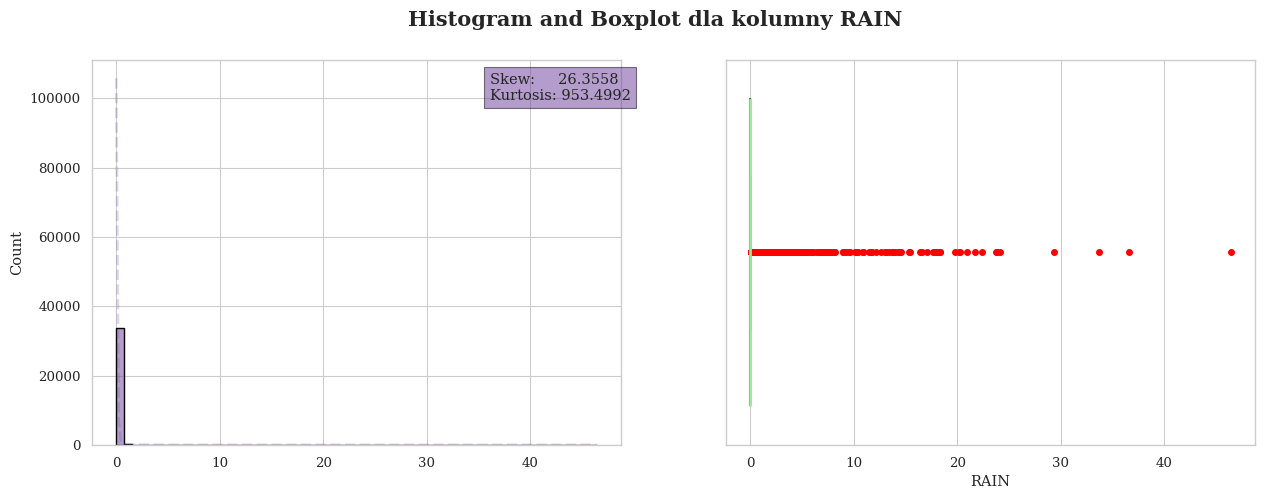

,count,mean,std,min,25%,50%,75%,max,RSD
RAIN,34368.0,0.063955,0.782207,0.0,0.0,0.0,0.0,46.4,1223.06


In [33]:
hist_box(dfc['RAIN'])

**RAIN**- Rozkład zmiennej jest silnie prawoskośny (skew = 26.3558) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w okolicy 0. Rozkład przybiera wyższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = 953.4992). Odchylenie standardowe (std = 0.782) i RSD = 1223.06 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

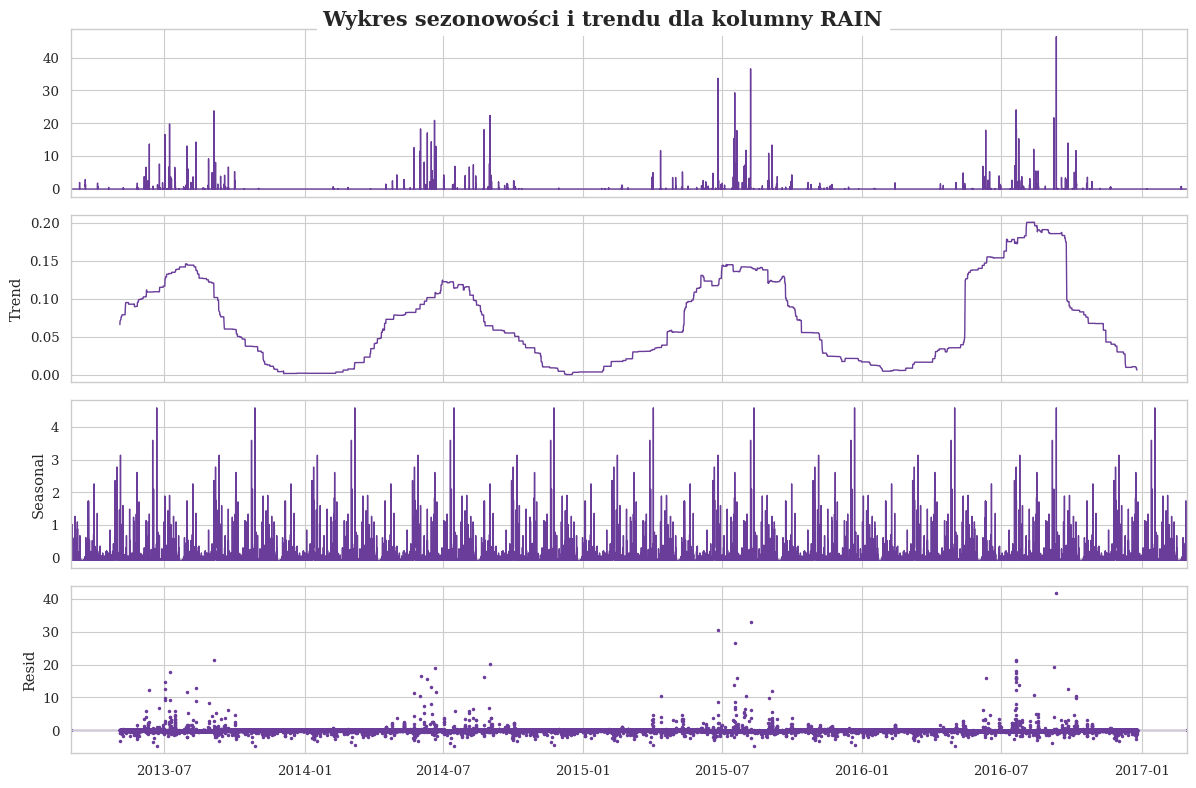

In [34]:
decomp (dfc['RAIN'], 3072)

Wykres sezonowości i trendu kolumny **RAIN** ukazuje minima w okolicach grudnia- lutego każdego roku (okres zimowy) i maksima w okolicach czerwca- sierpnia (okres letni). Sezonowośc jest powtarzalna w cyklu rocznym. Poziom trendu jest rosnący.

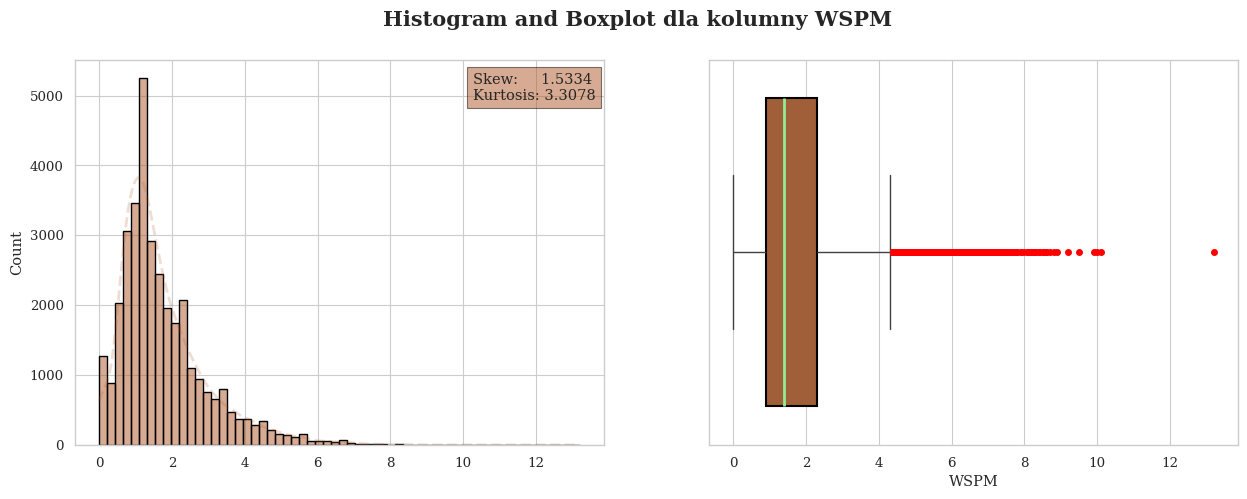

,count,mean,std,min,25%,50%,75%,max,RSD
WSPM,34368.0,1.74369,1.205465,0.0,0.9,1.4,2.3,13.2,69.13


In [35]:
hist_box(dfc['WSPM'])

**WSPM**- Rozkład zmiennej jest prawoskośny (skew = 1.5334) z długim ogonem dla wyższych wartości. Większość wartości jest skoncentrowana w niskich przedziałach. Rozkład przybiera wyższe wartości skrajne, niż wynikałoby to z rozkładu normalnego (kurtosis = 3.3078). Odchylenie standardowe (std = 1.205) i RSD = 69,13 oznacza, że wartości są w dużym stopniu rozrzucone wokół średniej. W kolumnie znajdują się wartości odstające, znajdujące się poza górnym zakresem 1.5 IQR.

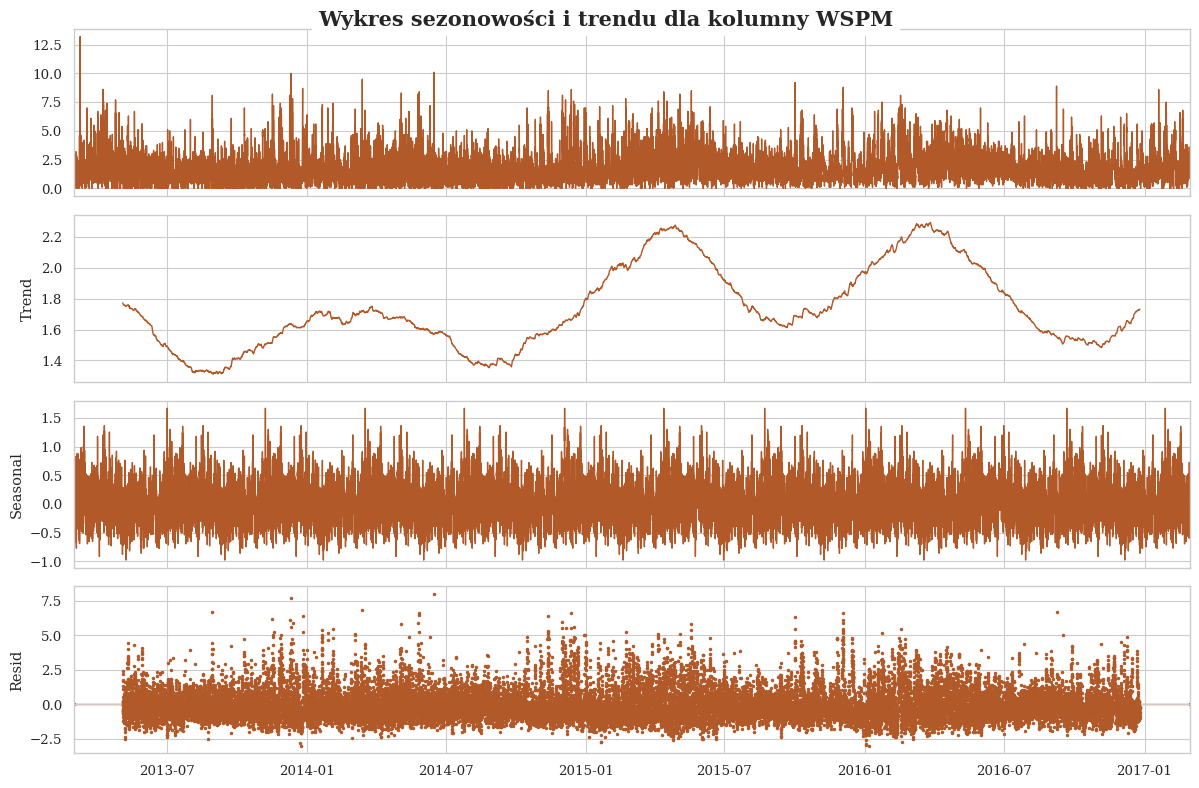

In [36]:
decomp (dfc['WSPM'], 3072)

Wykres sezonowości i trendu kolumny **RAIN** ukazuje minima w okolicach grudnia- lutego każdego roku (okres zimowy) i maksima w okolicach czerwca- sierpnia (okres letni). Sezonowośc jest powtarzalna w cyklu rocznym. Poziom trendu jest rosnący.

## Analiza korelacji między zmiennymi

Macierz korelacji ma na celu zobrazowanie zależności między wieloma zmiennymi. Współczynnik korelacji zawiera się w przedziale od -1 (silna korelacja ujemna- gdy jedna wartość rośnie, druga spada) do +1 (silna korelacja dodatnia- gdy jedna zmienna wzrasta, druga również wzrasta). Siła korelacji między zmiennymi określana jest na podstawie przedziałów :
- 0-0.1- brak związku,
- 0.1-0.3- słaby związek,
- 0.3-0.5- umiarkowany związek,
- 0.5-0.7- silny związek,
- 0.7-0.9- związek bardzo silny,
- 0.9-1 korelacja niemal pełna.

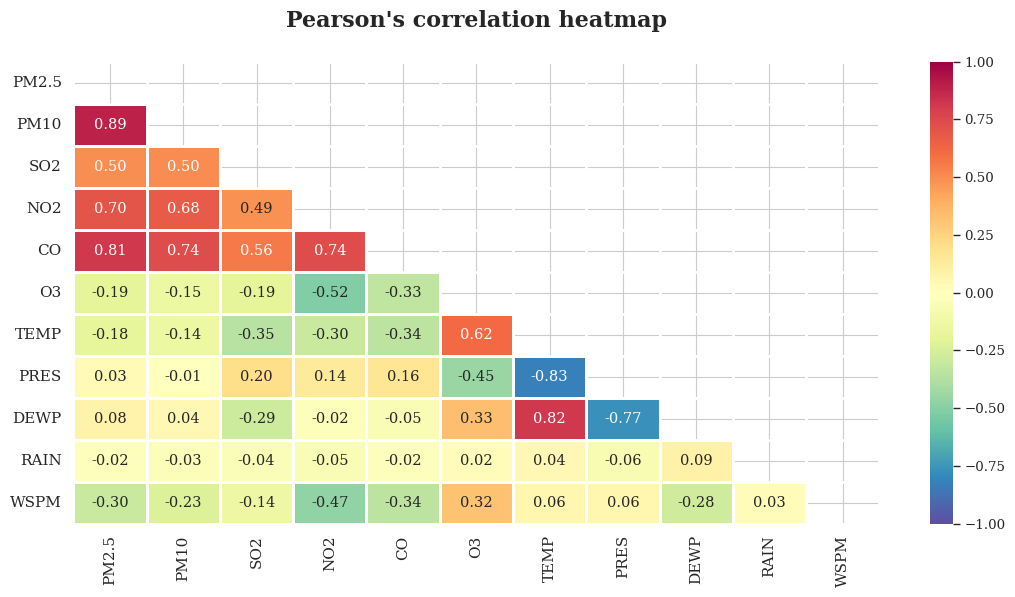

In [37]:
#stworzenie heatmapy
corr_matrix = dfc.corr()

mask = np.triu (np.ones_like(corr_matrix, dtype = bool))

fig= plt.figure (figsize = (13,6))

sns.heatmap (corr_matrix,
             annot = True, fmt = '.2f',
             linewidths = 2, linecolor = 'white',
             vmin = -1, vmax = 1,
             cmap = 'Spectral_r',
             mask = mask),

plt.xticks (fontname = 'serif', fontsize = 11, rotation = 90)
plt.yticks (fontname = 'serif', fontsize = 11, rotation = 0)
plt.title ("Pearson's correlation heatmap", fontsize = 16, fontweight = "bold", fontname = 'serif', pad = 25)

plt.show()

**PM2.5**- Przejawia bardzo silną korelację z poziomami pozostałych zanieczyszczeń: **PM10**, **NO2**, **CO**, silną korelację z **SO2**, słabą z **WSPM**, **TEMP**, **O3** i brak korelacji z **RAIN**, **DEWP**, **PRES**.

**PM10**- Bardzo silna korelacja z **PM2.5**, **CO** i silna korelacja z **SO2** i **NO2**. Słaba korelacja z **WSPM**, **TEMP** i **O3**. Brak korelacji z **PRES**, **DEWP** i **RAIN**.

**SO2**- Silna korelacja z **PM2.5**, **CO** i **PM10**, umiarkowana z **NO2** i **TEMP**. Słaby związek z **O3**, **PRES**, **DEWP** i **WSPM**. Brak związku z **RAIN**.

 **NO2**- Bardzo silna korelacja z **PM2.5**, **CO** oraz silna korelacja z **PM10** i **O3**. Umiarkowany związek z **SO2** i **WSPM**. Słaby związek z **TEMP**, **PRES**. Brak związku z **DEWP** i **RAIN**.

 **CO**- Bardzo silna korelacja z **PM2.5**, **PM10**, **NO2**. Silny związek z **SO2**. Umiarkowany związek z **O3** i **TEMP** i **WSPM**. Słaby związek z **PRES**. Brak związku z **DEWP** i **RAIN**.

**O3**- Silny związek z **TEMP** i **NO2**. Umiarkowany związek z **CO**, **PRES**, **DEWP** i **WSPM**. Słaby związek z **PM2.5**, **PM10**, **SO2**. Brak związku z **RAIN**.

**TEMP**- Bardzo silna korelacja z **PRES** i **DEWP**. Silny związek z **O3**. Umiarkowany związek z **SO2**, **NO2**, **CO**. Słaby związek z **PM2.5** i **PM10**. Brak związku z **RAIN** i **WSPM**.

**PRES**- Bardzo silna korelacja z **TEMP** i **DEWP**. Umiarkowany związek z **O3**. Słaby związek z **SO2**, **NO2** i **CO**. Brak związku z **PM2.5**, **PM10**, **RAIN** i **WSPM**.

**DEWP**- Bardzo silny związek z **PRES** i **TEMP**. Umiarkowany związek z **O3**. Słaby ziązek z **SO2** i **WSPM**. Brak związku z **PM2.5**, **PM10**, **NO2**, **CO** i **RAIN**.

**RAIN**- Brak korelacji ze wszystkimi zmiennymi.

**WSPM**- Umiarkowany związek z **PM2.5**, **NO2**, **CO**, **O3** i **DEWP**. Słaby związek z **PM10** i **SO2**. Brak związku z **TEMP**, **PRES** i **RAIN**.

**Podsumowanie**:
Dane dotyczące poziomów poszczególnych zanieczyszczeń są ze sobą w pewnym stopniu skorelowane. Podobnie jest z danymi dotyczącymi warunków atmosferycznych. Jednak dane dotyczące poziomów zanieczyszczeń nie mają zbyt dużego związku z warunkami atmosferycznymi. Zmienna **RAIN** nie wykazuje żadnego związku z pozostałymi zmiennymi.

# Przygotowanie danych do modelu

## Utworzenie zbioru zmiennych wejściowych X oraz wektora zmiennej celu y

In [38]:
#utworzenie zbioru zmiennych wejściowych X:
X = dfc.iloc[:,1:]

#utworzenie wektora zmiennej celu y:
y = dfc.iloc[:,0]

## Podział zbiorów X i y na zbiór treningowy i testowy

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42, shuffle = False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30931, 10), (3437, 10), (30931,), (3437,))

## Skalowanie danych

Skalowanie zbioru zmiennych wejściowych X za pomocą Robustscalera.

In [40]:
rbsc = RobustScaler()
X_train_sc = rbsc.fit_transform(X_train)
X_test_sc = rbsc.fit_transform(X_test)

Skalowanie wektora zmiennej celu y za pomocą Standardscalera

In [41]:
sc = StandardScaler()
y_train_sc = sc.fit_transform(y_train.to_frame())
y_train_sc = pd.Series(y_train_sc.flatten())

y_test_sc = sc.fit_transform(y_test.to_frame())
y_test_sc = pd.Series(y_test_sc.flatten())

# Utworzenie modelu

In [42]:
n_features = X.shape[1]
n_window = 24
batch_size = 128
train_gen = TimeseriesGenerator(X_train_sc, y_train_sc, length = n_window, sampling_rate = 1, batch_size = batch_size)
test_gen = TimeseriesGenerator(X_test_sc, y_test_sc, length = n_window, sampling_rate = 1, batch_size = batch_size)

In [43]:
model = Sequential()
model.add(Input((n_window, n_features)))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(8, return_sequences = False))
model.add(Dense(1, activation = 'linear'))

# Kompilacja i wytrenowanie modelu

In [44]:
#kompilacja modelu
model.compile(optimizer = 'adam', loss = 'mse', metrics = [tf.keras.metrics.R2Score()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          71,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 32)              │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,097 (363.66 KB)

 Trainable params: 93,097 (363.66 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#utworzenie callback'a
early_stopping = EarlyStopping (monitor = 'val_loss', patience = 20, restore_best_weights = True)

#wytrenowanie modelu
fit = model.fit(train_gen, epochs = 500, validation_data = test_gen, callbacks = [early_stopping])

Epoch 1/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.6244 - r2_score: 0.4045 - val_loss: 0.3132 - val_r2_score: 0.6879
Epoch 2/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4822 - r2_score: 0.6140 - val_loss: 0.1704 - val_r2_score: 0.8302
Epoch 3/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2694 - r2_score: 0.7496 - val_loss: 0.1376 - val_r2_score: 0.8629
Epoch 4/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2251 - r2_score: 0.7894 - val_loss: 0.1302 - val_r2_score: 0.8703
Epoch 5/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1609 - r2_score: 0.8331 - val_loss: 0.1207 - val_r2_score: 0.8798
Epoch 6/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1645 - r2_score: 0.8334 - val_loss: 0.1187 - val_r2_score: 0.8817
Epoch 7/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1359 - r2_score: 0.8480 - val_loss: 0.1243 - val_r2_score: 0.8761
Epoch 8/500
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1479 - r2_score: 0.8603 - val_l

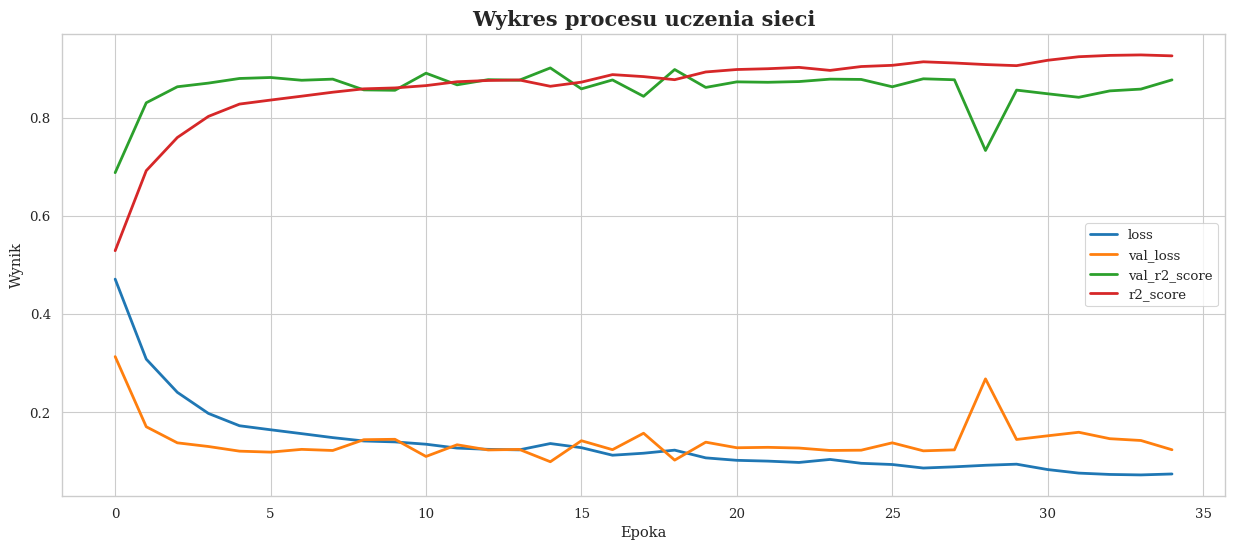

In [46]:
#utworzenie wykresu procesu uczenia sieci
plt.figure(figsize = (15, 6))

plt.plot(fit.history['loss'], '-', label = 'loss')
plt.plot(fit.history['val_loss'], '-', label = 'val_loss')
plt.plot(fit.history['val_r2_score'], '-', label = 'val_r2_score')
plt.plot(fit.history['r2_score'], '-', label = 'r2_score')

plt.title ('Wykres procesu uczenia sieci', {'fontsize': 15,
 'fontweight': 'semibold'})
plt.xlabel('Epoka')
plt.ylabel('Wynik')
plt.legend()

# Ocena jakości wytrenowanego modelu

## Odwrotne skalowanie zmiennej celu

In [47]:
y_train_inv = sc.inverse_transform(y_train_sc.to_frame())
y_test_inv = sc.inverse_transform(y_test_sc.to_frame())

## Predykcja dla danych treningowych i testowych

In [48]:
train_pred = model.predict(train_gen, verbose = 0)
test_pred = model.predict(test_gen, verbose = 0)

## Odwrotne skalowanie wyników predykcji

In [49]:
test_pred_true = sc.inverse_transform(test_pred)[:, 0]
train_pred_true = sc.inverse_transform(train_pred)[:, 0]
test_pred_true.shape, train_pred_true.shape

((3413,), (30907,))

## Obliczenie wartości MSE i współczynnika R2 dla danych treningowych i testowych

In [50]:
#metryki dla danych treningowych
train_mse, train_r2_score = model.evaluate(train_gen, verbose=0)

#metryki dla danych testowych
test_mse, test_r2_score = model.evaluate(test_gen, verbose=0)

metrics = pd.DataFrame({'MSE': [train_mse, test_mse],
                        'R2': [train_r2_score, test_r2_score]},
                       index = ['Train', 'Test'])
metrics

,MSE,R2
Train,0.119963,0.880052
Test,0.099111,0.901246


## Wykres liniowy prawdziwych oraz przewidzianych przez model wartości PM2.5

In [51]:
df_test = dfc[-test_pred_true.shape[0]:]
df_test.insert(1, 'Pred_PM2.5', test_pred_true)

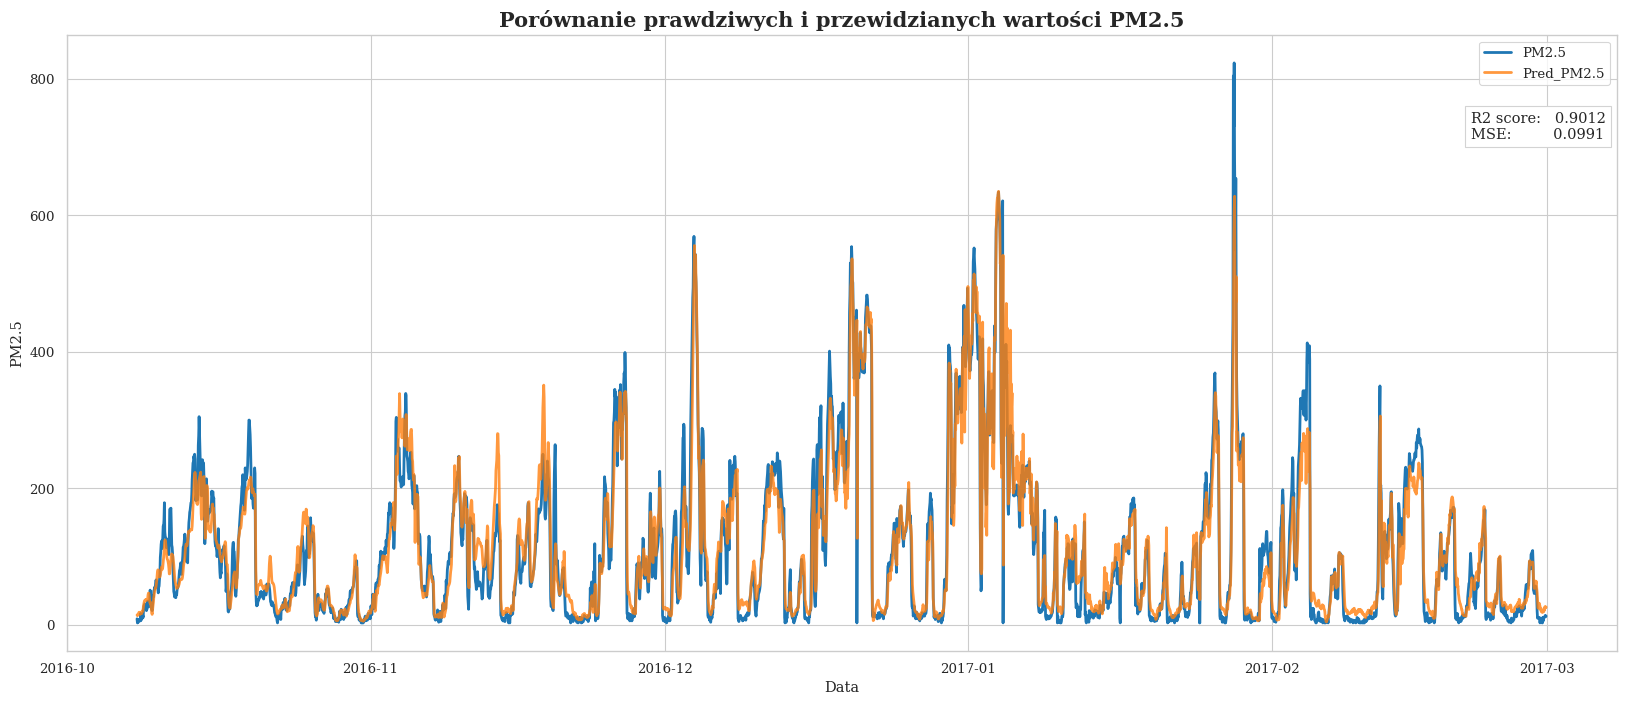

In [52]:
plt.figure(figsize = (20, 8))

plt.plot(df_test['PM2.5'], '-', label = 'PM2.5')
plt.plot(df_test['Pred_PM2.5'], '-', label = 'Pred_PM2.5', alpha = 0.8)

plt.title ('Porównanie prawdziwych i przewidzianych wartości PM2.5', {'fontsize': 15,
 'fontweight': 'semibold'})
plt.xlabel('Data')
plt.ylabel('PM2.5')
plt.text(0.827, 0.75, f'R2 score:   {round(test_r2_score, 4)}\nMSE:         {round(test_mse, 4)}',
             bbox = dict(facecolor = 'white',
                         edgecolor = 'lightgrey'),transform = plt.gcf().transFigure)
plt.legend()

# Dyskusja przebiegu projektu, wyniki i wnioski

**Przebieg projektu**

W ramach projektu dokonano predykcji poziomu zanieczyszczenia cząsteczkami PM2.5 na bazie poziomów innych zanieczyszczeń oraz warunków atmosferycznych. Zbiór danych zawierał wartości puste, bez duplikatów. W przypadku zmiennej celu PM2.5 wiersze puste usunięto, natomiast w dla pozostałych zmiennych wartości zostały uzupełnione metodą interpolacji liniowej.

Wykonano eksploracyjną analizę danych, która wykazała, że rozkłady dużej części zmiennych są prawoskośne i zawierają outliery. Nie wykonywano przekształcenia zmiennych, ani usunięcia outlierów.

Wykonano również analizę korelacji między zmiennymi, która wykazała, że dane dotyczące poziomów poszczególnych zanieczyszczeń są ze sobą w pewnym stopniu skorelowane. Podobnie jest z danymi dotyczącymi warunków atmosferycznych. Przy czym dane dotyczące poziomów zanieczyszczeń nie mają zbyt dużego związku z warunkami atmosferycznymi.

Z uwagi na obecność outlierów dane wejściowe przeskalowano RobustScalerem, który wykazuje na nie większą odporność. Wektor zmiennej celu został przeskalowany StandardScalerem.

Dane treningowe i testowe utworzono za pomocą TimeseriesGenerator, z założeniem rozmiaru okna (n_window) 24 i paczki (batch_size) 128, co zapewniło optymalną prędkość uczenia. Utworzono model sekwencyjny z trzema warstwami LSTM o ilości neuronów odpowiednio 128, 32 i 8 oraz z warstwą gęstą o 1 neuronie i liniowej aktywacji. Eksperymenty z większymi ilościami neuronów nie przyniosły zadowalających rezultatów. Model skompilowano z użyciem optymizera 'adam' i metrykami MSE i R2 score. Dokonano predykcji na danych treningowych i testowych, obliczono metryki i porównano wartości prawdziwe i przewidziane zmiennej celu PM2.5

**Wyniki**

Mimo braku przekształcenia zmiennych do rozkładu bardziej przypominającego normalny oraz nieusunięcia outlierów, osiągnięto zadowalające parametry MSE i R2:

Dla zbioru treningowego:  MSE = 0.119963 R2 =	0.880052

Dla zbioru testowego: MSE = 0.099111 R2 = 0.901246

Poza protokołem wykonano drugą wersję projektu, w której dokonano przekształcenia danych przy pomocy PowerTransformera metodą 'yeo-johnson' oraz usunięcia outlierów. Otrzymane metryki MSE i R2 dla zbioru testowego były niemalże identyczne, jednak model zauważalnie gorzej odnajdywał się w wysokich poziomach stężenia PM2.5. Tym samym model został finalnie odrzucony.

**Wnioski**

Otrzymany model jest dobrze dopasowany do danych, a wysoka wartość R2 oznacza, że model dobrze przewiduje ich zmienność. Wyższa wartość R2 i niższa wartość MSE na zbiorze testowym, w porównaniu do zbioru treningowwego oznacza, że model dobrze generalizuje dane i nie wykazuje oznak przeuczenia.
